<a href="https://colab.research.google.com/github/prathvikgs/PINNs-Max-Planck-Institute-CBG-Summer-2023/blob/main/Cell_List_Quadrature_Copy2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import style
import matplotlib
matplotlib.rcdefaults()
import random
import sys
#sys.path.insert(1,  '/content/PSM_V1')
#from sobolev import Sobolev
import time

In [49]:
'Classes for storing particle and there properties in a structured way'

class Props:
    def __init__(self,field_val,derivs):
        self.field=field_val
        self.field_derivative=derivs
#----------------------------------------------------#
class Particle:
    def __init__(self,position,properties):
        self.position=position
        self.properties=properties

    def interact(self,other_particle):
        pass

    def evolve(self):
        pass
#----------------------------------------------------#
class ParticleSet:
    # positions: array of shape(N,d)
    # properties: array of shape(N,1)

    def __init__(self,positions,properties):
        self.num_particles = positions.shape[0]
        self.spatial_dimension = positions.shape[1]
        self.particles=[]
        for i in range(self.num_particles):
            self.particles.append(Particle(positions[i,:],properties[i]))

    def update_once(self):
        pass

    def compute_derivatives(self,celllist, deriv_func, eps, V):
        for p_idx, p in enumerate(self.particles):
            result = 0.0
            x=p.position
            cell_idx=np.floor((x)/rc).astype(int)
            neighbours = celllist.neightbourhood(cell_idx)
            for q in neighbours:
                if(q!=p_idx):
                  z=p.position-self.particles[q].position
                  result+=self.particles[q].properties.field * deriv_func(z, eps) * V
            p.properties.field_derivative = result
        return


In [50]:
'''
Overall, the CellList class provides methods to construct a cell-based data structure for particles,
retrieve particles within a specific cell, and obtain a neighborhood of particles around a given cell
'''

class CellList:

    def __init__(self,particle_set,rc):
        self.cells = {}
        self.construct(particle_set, rc)
        self.particle_set = particle_set

        '''The CellList class has an __init__ method that initializes the object
        It takes two parameters: particle_set, which is an object representing a set of particles,
        and rc, which is a distance threshold '''

    def construct(self, particle_set, rc):
        '''
        The construct method takes a particle_set and rc as parameters.
        It iterates over the particles in the particle_set and calculates the cell index for each particle based on its position.
        The position is divided by rc, which is then floored and converted to an integer.
        The cell index is extracted from the resulting array (cell_index_x) by taking the first element (cell_index_x[0]).
        The method checks if the calculated cell index already exists in the cells dictionary.
        If it does, it appends the current particle index (idx) to the list associated with that cell index.
        If the cell index is not present in the dictionary, a new key-value pair is created
        with the cell index as the key and a list containing the particle index as the value.
        '''
        for idx,p in enumerate(particle_set.particles):
            cell_index_x = np.floor((p.position)/rc).astype(int)
            cell_index=cell_index_x[0]
            if cell_index in self.cells.keys():
                self.cells[cell_index].append(idx)
            else:
                self.cells[cell_index]=[idx]

    def particles_in(self, cell_index):

        '''
        The particles_in method takes a cell_index as a parameter and returns the list of particle indices
        associated with that cell index. If the cell index is present in the cells dictionary,
        the corresponding list is returned. Otherwise, an empty list is returned.
        '''
        if cell_index in self.cells.keys():
            return self.cells[cell_index]
        else:
            return []


    def neightbourhood(self, cell_index):
        '''The neighbourhood method takes a cell_index as a parameter and returns a list of particle
        indices representing the neighborhood particles. It considers the cell with cell_index and its adjacent
        cells in the x-direction (left, current, right). It iterates over the list [-1, 0, 1] and
        extends the neighbour_list with the particle indices returned by self.particles_in(cell_index_x + lx).
        '''
        cell_index_x=cell_index[0]
        neighbour_list=[]
        for lx in [-1,0,1]:
            neighbour_list.extend(self.particles_in(cell_index_x+lx))
        return neighbour_list


    #these is only for 1D
    def cells_affected_shock(self,shock_ini, shock_final):
        '''
        shock_ini and shock_final are initial and final position of shock
        '''
        cell_index_x_ini = np.floor((shock_ini)/rc).astype(int)
        cell_index_ini=cell_index_x_ini[0]

        cell_index_x_final = np.floor((shock_final)/rc).astype(int)
        cell_index_final=cell_index_x_final[0]

        'finding the cells affected by the movement of the shock'
        affected_list=[]

        for i in range(min(cell_index_ini,cell_index_final),max(cell_index_ini,cell_index_final)+1):
            affected_list.append(i)

        return affected_list

    def particles_affected(self,shock_ini,shock_final):
        'particles affected by the moving shock'
        affected_cells=self.cells_affected_shock(shock_ini,shock_final)
        particle_idx_affected=[]
        for x in affected_cells:
            p=celllist.particles_in(x)
            for idx in p:
                particle_idx_affected.append(idx)

        return particle_idx_affected

    def coord_affected(self,shock_ini,shock_final):
        'particles affected by the moving shock'
        affected_cells=self.cells_affected_shock(shock_ini,shock_final)
        positions_affected=[]
        for x in affected_cells:
            p=celllist.particles_in(x)
            for idx in p:
                positions_affected.append(self.particle_set.particles[idx].position[0])

        return positions_affected

In [51]:
'''Function we want aproximate'''
def f(x):
    return  np.sin(10*x)*x**2

'''Derivative of the function'''
def dfdx(x):
    return 2*x*(5*x*np.cos(10*x) + np.sin(10*x))


'''Kernel we will be using'''
def kernel(z, eps):
    alphad = 2.0/eps
    z = np.abs(z)
    if z < 0.5*eps:
        return alphad*(2.0/3.0 - (2.0*z/eps)**2 + 0.5*(2.0*z/eps)**3)
    elif z >= 0.5*eps and z < eps:
        return alphad*(((1.0/6.0)*(2.0-2.0*z/eps)**3))
    else:
        return 0.0

"Derivative of the kernel we will be using"
def deriv_kernel(z, eps):
    if z!=0:
        sign = z/np.abs(z)
    else:
        sign = 1
    z = np.abs(z)
    alphad = sign*2.0/eps
    if z < 0.5*eps:
        return alphad*((-8.0*z/(eps**2)) + (12.0*z**2/eps**3))
    elif z >= 0.5*eps and z < eps:
        return alphad*(-1*(2.0-2.0*z/eps)**2/eps)
    else:
        return 0.0

In [53]:
N = 1000
d = 1
x_l=-1
x_r=+1
positions = np.linspace(x_l,x_r,N)
positions = positions.reshape(N,1)
h=positions[1]-positions[0]
eps=2*h
rc = 5.0*h
properties=[]
for i in range(N):
    properties.append(Props(f(positions[i]),0.0))

pset=ParticleSet(positions,properties)
celllist=CellList(pset,rc)
pset.compute_derivatives(celllist,deriv_kernel,2*h,h)
print(pset.particles[10].properties.field_derivative)
print(pset.particles[10].position)
#print(pset.particles[0].properties.field)

[-9.65336908]
[-0.97997998]


Predictions without using cell lists

In [54]:
'''
start=time.time()
#evaluating the function using the cubic spline sph kernel
def f_pred(x,pset):
  result=0.0
  h=pset.particles[1].position-pset.particles[0].position
  for i in range(len(positions)):
    y=pset.particles[i].position[0]
    result+=f(y)*kernel(abs(y-x),eps)*h
  return result

#evaluating the derivative of the function using the cubic spline sph kernel
def derive_pred(x,pset):
  result=0.0
  h=pset.particles[1].position-pset.particles[0].position
  eps = 2*h
  for i in range(len(positions)):
    y=pset.particles[i].position[0]
    result+=f(y)*deriv_kernel((x-y),eps)*h
  return result

x_p=np.linspace(-1,1,N)
y_p=[]
dfx=[]
for k in range(len(x_p)):
  dfx.append(derive_pred(x_p[k] ,pset))
  y_p.append(f_pred(x_p[k] ,pset))

f1=plt.figure(1)
plt.plot(x_p[2:-2],y_p[2:-2],color='red')
plt.plot(positions[2:-2],f(positions)[2:-2],color='blue')

f2=plt.figure(2)
plt.plot(x_p[2:-2],dfx[2:-2],color='red')
plt.plot(positions[2:-2],dfdx(positions)[2:-2],color='blue')
stop=time.time()
plt.show()
print(" ")
print("Time=",stop-start)
print(" ")
'''

'\nstart=time.time()\n#evaluating the function using the cubic spline sph kernel\ndef f_pred(x,pset):\n  result=0.0\n  h=pset.particles[1].position-pset.particles[0].position\n  for i in range(len(positions)):\n    y=pset.particles[i].position[0]\n    result+=f(y)*kernel(abs(y-x),eps)*h\n  return result\n\n#evaluating the derivative of the function using the cubic spline sph kernel\ndef derive_pred(x,pset):\n  result=0.0\n  h=pset.particles[1].position-pset.particles[0].position\n  eps = 2*h\n  for i in range(len(positions)):\n    y=pset.particles[i].position[0]\n    result+=f(y)*deriv_kernel((x-y),eps)*h\n  return result\n\nx_p=np.linspace(-1,1,N)\ny_p=[]\ndfx=[]\nfor k in range(len(x_p)):\n  dfx.append(derive_pred(x_p[k] ,pset))\n  y_p.append(f_pred(x_p[k] ,pset))\n\nf1=plt.figure(1)\nplt.plot(x_p[2:-2],y_p[2:-2],color=\'red\')\nplt.plot(positions[2:-2],f(positions)[2:-2],color=\'blue\')\n\nf2=plt.figure(2)\nplt.plot(x_p[2:-2],dfx[2:-2],color=\'red\')\nplt.plot(positions[2:-2],dfdx(p

By using CellLists

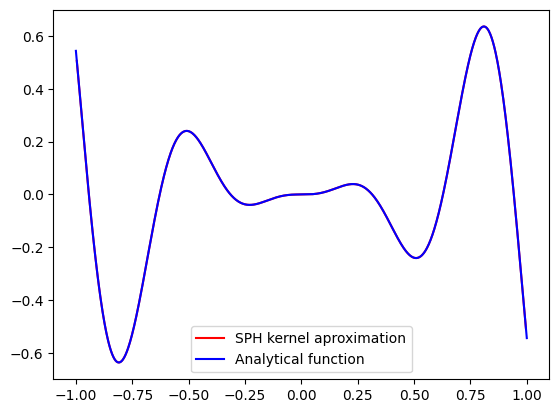

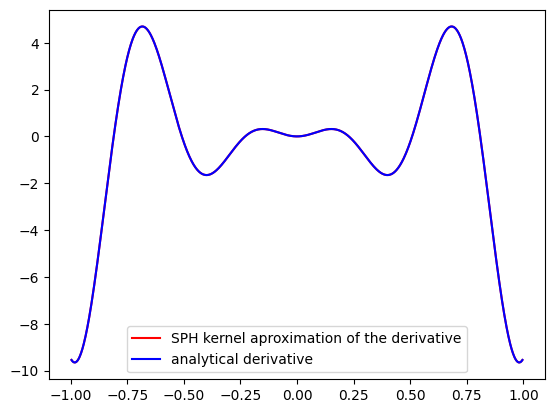

 
Time= 1.6365725994110107
 


In [ ]:
start=time.time()
def f_pred_c(x,pset):
  result=0.0

  cell_index=np.floor((x)/rc).astype(int)
  neighbours=celllist.neightbourhood(cell_index)

  for p in neighbours:
      y=pset.particles[p].position[0]
      result+=f(y)*kernel(abs(y-x),eps)*h

  return result

def derive_pred_c(x,pset):
  result=0.0
  cell_index=np.floor((x)/rc).astype(int)
  neighbours=celllist.neightbourhood(cell_index)

  for p in neighbours:
      y=pset.particles[p].position
      result+=f(y)*deriv_kernel((x-y),eps)*h

  return result

x_p=np.linspace(-1,1,N)
y_p=[]
dfx=[]
for k in range(len(x_p)):
  dfx.append(derive_pred_c(x_p[k] ,pset))
  y_p.append(f_pred_c(x_p[k] ,pset))

f1=plt.figure(1)
plt.plot(x_p[2:-2],y_p[2:-2],color='red',label='SPH kernel aproximation')
plt.plot(positions,f(positions),color='blue',label='Analytical function')
leg = plt.legend()
plt.show()
f2=plt.figure(2)
plt.plot(x_p[2:-2],dfx[2:-2],color='red',label='SPH kernel aproximation of the derivative')
plt.plot(positions[2:-2],dfdx(positions)[2:-2],color='blue',label='analytical derivative')
leg = plt.legend()
plt.show()
stop=time.time()

print(" ")
print("Time=",stop-start)
print(" ")

Code for runtime comparision

In [ ]:
start=time.time()
def f_pred_c_comp(x,pset,positions,celllist):

  result=0.0
  cell_index=np.floor((x)/rc).astype(int)
  neighbours=celllist.neightbourhood(cell_index)

  for p in neighbours:
      y=pset.particles[p].position[0]
      result+=f(y)*kernel(abs(y-x),eps)*h

  return result

def derive_pred_c_comp(x,pset,positions,celllist):
  result=0.0
  cell_index=np.floor((x)/rc).astype(int)
  neighbours=celllist.neightbourhood(cell_index)

  for p in neighbours:
      y=pset.particles[p].position
      result+=f(y)*deriv_kernel((x-y),eps)*h

  return result
def f_pred_comp(x,pset,positions):
  result=0.0
  h=pset.particles[1].position-pset.particles[0].position
  for i in range(len(positions)):
    y=pset.particles[i].position[0]
    result+=f(y)*kernel(abs(y-x),eps)*h
  return result

#evaluating the derivative of the function using the cubic spline sph kernel
def derive_pred_comp(x,pset,positions):
  result=0.0
  h=pset.particles[1].position-pset.particles[0].position
  eps = 2*h
  for i in range(len(positions)):
    y=pset.particles[i].position[0]
    result+=f(y)*deriv_kernel((x-y),eps)*h
  return result

In [ ]:
def compare(N):

    start=time.time()

    x_l=-1
    x_r=+1
    positions = np.linspace(x_l,x_r,N)
    positions = positions.reshape(N,1)
    h=positions[1]-positions[0]
    eps=2*h
    rc = 5.0*h
    properties=[]
    for i in range(N):
        properties.append(Props(f(positions[i]),0.0))

    pset=ParticleSet(positions,properties)
    celllist=CellList(pset,rc)
    x_p=np.linspace(-1,1,N)
    y_p=[]
    dfx=[]
    for k in range(len(x_p)):
       dfx.append(derive_pred_c_comp(x_p[k] ,pset,positions,celllist))
       y_p.append(f_pred_c_comp(x_p[k] ,pset,positions,celllist))
    end=time.time()

    time1=end-start

    start=time.time()
    y_p=[]
    dfx=[]
    for k in range(len(x_p)):
        dfx.append(derive_pred_comp(x_p[k] ,pset,positions))
        y_p.append(f_pred_comp(x_p[k] ,pset,positions))

    end=time.time()
    time2=end-start

    return time1,time2


K=[10,100,200,400,600,1000,2000]
time1=[]
time2=[]
for i in range(len(K)):
  t1,t2=compare(K[i])
  time1.append(t1)
  time2.append(t2)

plt.plot(K,time1,color='blue',label='Using CellLists')
plt.plot(K,time2,color='red',label='Without CellList')
plt.xlabel('No. of particles')
plt.ylabel('time in seconds')
plt.title('Comparision of runtime')
leg = plt.legend()
plt.show()

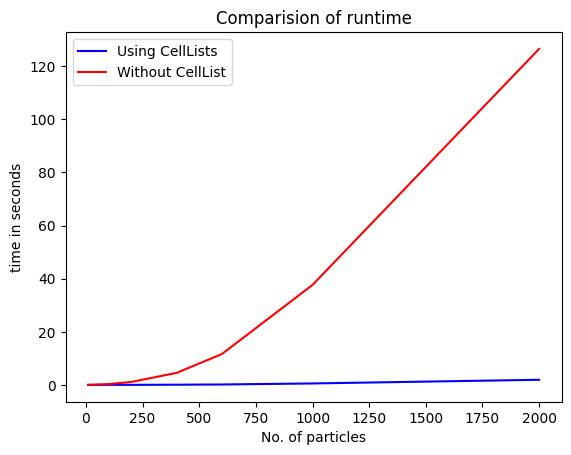

In [ ]:
def aff_points(l_lim, u_lim):
  affected=celllist.coord_affected(l_lim,u_lim)
  return affected

affected=celllist.particles_affected(0.2,0.5)
affected_pos=[]
for p in affected:
    affected_pos.append(pset.particles[p].position[0])


(-0.3100578, 0.5100001000000001)

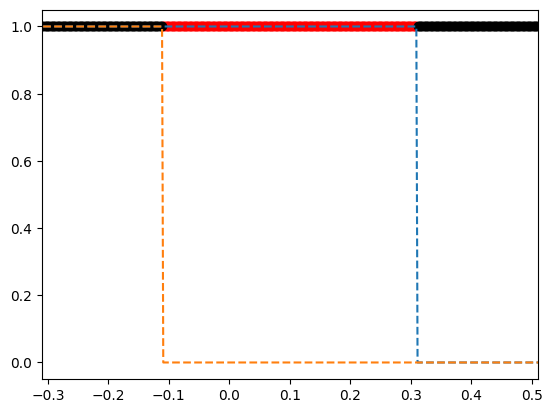

In [ ]:
shock = [0.3100001,-0.1100578]
affected_pos = aff_points(shock[0],shock[1])
H_c0 = np.zeros(len(positions))
H_c0[(positions<=shock[0]).T[0]] = 1
H_c1 = np.zeros(len(positions))
H_c1[(positions<=shock[1]).T[0]] = 1
plt.plot(positions,H_c0, linestyle = '--',label='tt')
plt.plot(positions, H_c1, linestyle = '--')
plt.scatter(affected_pos,np.linspace(1,1,len(affected_pos)), color ='red',marker ='o' )
diff_c = np.array(list(set(positions.T[0])-set(affected_pos)))
plt.scatter(diff_c,np.linspace(1,1,len(diff_c)), color ='black',marker ='o' )
plt.xlim([min(shock[0],shock[1])-0.2,max(shock[0],shock[1])+0.2])
